In [1]:
###############
### Imports ###
###############
from datetime import datetime 
import os
import csv
import random
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.callbacks import * 
import matplotlib.pyplot as plt
import tensorflow.keras.models as models 
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from tensorflow.keras.layers import Conv2D, Dropout, AveragePooling2D, MaxPooling2D, Flatten, Dense, LSTM, BatchNormalization
from tensorflow.keras import regularizers 

Using TensorFlow backend.


In [2]:
###########################
### Basic configuration ###
###########################

# Ignore warnings about deprecated features
warnings.simplefilter(action = "ignore")

# Check the number of available GPUs
physical_devices = tf.config.experimental.list_physical_devices("GPU")
print("Number of GPUs Available:", len(physical_devices))

# Set if memory growth should be enabled for a PhysicalDevice
if physical_devices: tf.config.experimental.set_memory_growth(physical_devices[0], True)

Number of GPUs Available: 1


In [3]:
############################################
#### Generation of the score dictionary  ### 
############################################

# Initialize the score dictionary
scores = {}
# Opening the score csv file
with open("../scores.csv", mode = "r", encoding = "utf-8-sig") as file:
  # Reading the csv file
  scoreFile = csv.reader(file, delimiter = ";")
  # Save the contents of the CSV file
  for lines in scoreFile: 
    id = lines[0]
    score = lines[1]
    scores[id] = score

In [4]:
######################################################
### Generation of the locomotion matrix dictionary ###
######################################################

# Get the list of locomotion data files 
listLocomotionData = os.listdir("../Locomotion")

# Initialize the data dictionary
data = {}
# Get the list of sensor names
sensor_names = pd.read_excel("../Locomotion/" + listLocomotionData[0]).columns

# Iterate through the score dictionary
for key, value in scores.items(): 
  # Iterate through the list of locomotion data files 
  for locomotion in listLocomotionData: 
    if key in locomotion:
      df = pd.read_excel ("../Locomotion/" + locomotion)
      df = df.dropna(how = "all")
      df = df.fillna(0)
      df = df.to_numpy()
      data[key] = df

In [5]:
######################################
### Set dimensions of the matrices ###
######################################

# Initialize the number of rows and columns
n_rows = []
n_columns = 60

# Iterate through the data dictionary
for key, value in data.items(): 
  # Save the number of rows of the actual array
  n_rows.append(value.shape[0])
    
# Set the number of rows for all arrays with the maximum number of rows available 
n_rows = max(n_rows)
# Print the number of rows and columns
print("COLUMNS:", n_columns, "ROWS:", n_rows)

COLUMNS: 60 ROWS: 502


In [6]:
#############################################################
### Generation of matrices and imputation of missing data ###
#############################################################

# Initialize the feature matrix and the class vector
X = []
y = []

# Iterate through the data dictionary
for key, value in data.items():
  
  # Build the features matrix
  if scores[key] == "2" or scores[key] == "2,5" or scores[key] == "3" or scores[key] == "3,5":
    matrix = []
    for i in range(n_columns):
      sequence = []
      for j in range(n_rows):
        try: sequence.append(float(value[j][i]))
        except:sequence.append(float(0))
      sequence = np.array(sequence)
      matrix.append(sequence)
    matrix = np.array(matrix)
    X.append(matrix)

    # Save the classes
    if scores[key] == "2": y.append(0)
    elif scores[key] == "2,5":y.append(1)
    elif scores[key] == "3":y.append(2)
    elif scores[key] == "3,5" :y.append(3)
    else: pass

# Print the distributions of the classes
print("Number of cows with class 2: ", y.count(0))
print("Number of cows with class 2.5: ", y.count(1))
print("Number of cows with class 3: ", y.count(2))
print("Number of cows with class 3.5: ", y.count(3))

# Transform the matrix avec vector to numpy array
X = np.array(X)
y_array = np.array(y)

Number of cows with class 2:  20
Number of cows with class 2.5:  30
Number of cows with class 3:  19
Number of cows with class 3.5:  5


In [7]:
#############################
### Get data informations ###
#############################

n_instances = X.shape[0]
n_features = X.shape[1]
n_values = X.shape[2]
print("Number of instances =", n_instances, 
      "\nNumber of features per instance =", n_features, 
      "\nNumber of values per feature =", n_values)

print(" ")

print("Matrice =", X.shape)
print("Classes =", set(y))
print("Example of instance =\n", X[0])
print("First value of the first feature of the first instance =", X[0][0][0])
print("Middle value of the middle feature of the middle instance =", X[int(n_instances / 2)][int(n_features /2)][int(n_values /2)])
print("Last value of the last feature of the last instance =", X[n_instances - 1][n_features - 1][n_values - 1])

Number of instances = 74 
Number of features per instance = 60 
Number of values per feature = 502
 
Matrice = (74, 60, 502)
Classes = {0, 1, 2, 3}
Example of instance =
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
First value of the first feature of the first instance = 0.0
Middle value of the middle feature of the middle instance = 29.043
Last value of the last feature of the last instance = 0.0


In [8]:
# construct the training and testing splits
(X_train, X_test, y_train, y_test) = train_test_split(X, y_array, stratify = y_array, 
	test_size=0.25, shuffle = True)

print("Length of training data: ", len(X_train))
print("Length of validation data: ", len(X_test))

Length of training data:  55
Length of validation data:  19


In [9]:
#################################
### Perform data augmentation ###
#################################

import time
start = time.time() # Data augmentation takes roughly 10 minutes

## ONLY AUGMENT THE TRAINING DATA! 

# Initialize the feature matrix and the class vector for generated data
X_Generated = []
y_Generated = []

# Set the variation percentage for random noise generation
variation_percentage = 1

# Iterate through the instances of X
for i, x in enumerate(X_train):
    
    # Set the number of instance to generate balanced dataset (roughly ~2500 instances of each class)
    if y_train[i] == 0: n_generated_instances = 2500 // (y_train == 0).sum()
    if y_train[i] == 1: n_generated_instances = 2500 // (y_train == 1).sum()
    if y_train[i] == 2: n_generated_instances = 2500 // (y_train == 2).sum()
    if y_train[i] == 3: n_generated_instances = 2500 // (y_train == 3).sum()
    
    # Iterate through the inumber of instances to generate
    for j in range(int(n_generated_instances)):
        # Initialize the vector to save the new matrix
        x_Generated = []
        # Iterate through the row of the actual instance
        for row in x:
            # Initialize the vector to save the new row
            x_Generated_Row = []
            # Iterate through the value of the actual row
            for value in row:
                # Generate random variation for the instance
                random_number = random.random()  * variation_percentage / 100
                # Generate boolen to add or remove the variation
                boolean = random.randint(0 , 1)
                # Save value adding variation
                if boolean == 0: x_Generated_Row.append(value + value * random_number)
                # Save value removing variation
                else: x_Generated_Row.append(value - value * random_number)
            # Convert the row vector to numpy array
            x_Generated_Row = np.array(x_Generated_Row)
            # Save the row vector
            x_Generated.append(x_Generated_Row)
        # Convert the matrix vector to numpy matrix
        x_Generated = np.array(x_Generated)
        # Save the generated matrix
        X_Generated.append(x_Generated)
        # Save the associated classes
        y_Generated.append(y_train[i])

# Transform the matrix avec vector to numpy array
X_Generated = np.array(X_Generated)
y_Generated = np.array(y_Generated)

end = time.time()
print("Time taken to perform data augmentation: ", (end - start))

Time taken to perform data augmentation:  581.9985754489899


In [10]:
#####################################
### Display the data informations ###
#####################################

"""
print("Matrice:", X_Generated.shape)
print("Classes:", set(y_Generated))
print("Number of targets: ", y_Generated.shape)
print("Example of instance:", X_Generated[0])
print("Example of shape of instance:", X_Generated[0].shape)
"""

'\nprint("Matrice:", X_Generated.shape)\nprint("Classes:", set(y_Generated))\nprint("Number of targets: ", y_Generated.shape)\nprint("Example of instance:", X_Generated[0])\nprint("Example of shape of instance:", X_Generated[0].shape)\n'

In [11]:
#####################################
### Reshape the data for training ###
#####################################

print("X_train shape =", X_Generated.shape)
print("X_test shape =", X_test.shape)

X_train shape = (9968, 60, 502)
X_test shape = (19, 60, 502)


In [12]:
########################
### LSTM Model Train ###
########################

# Build model
LSTM_model = models.Sequential()
LSTM_model.add(LSTM(32, input_shape = (n_features, n_values), return_sequences = True))
LSTM_model.add(Dropout(0.25))
LSTM_model.add(BatchNormalization())
LSTM_model.add(LSTM(64, return_sequences = True))
LSTM_model.add(Dropout(0.25))
LSTM_model.add(BatchNormalization())
#LSTM_model.add(LSTM(128, return_sequences = True))
#LSTM_model.add(Dropout(0.25))
#LSTM_model.add(BatchNormalization())
#LSTM_model.add(LSTM(64, return_sequences = True))
#LSTM_model.add(Dropout(0.25))
#LSTM_model.add(BatchNormalization())
LSTM_model.add(LSTM(32))
LSTM_model.add(Dropout(0.25))
LSTM_model.add(BatchNormalization())
LSTM_model.add(Dense(32, activation = 'relu'))
LSTM_model.add(Dropout(0.25))
LSTM_model.add(Dense(4, activation = 'softmax'))

# Display summary of the model
LSTM_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 32)            68480     
_________________________________________________________________
dropout (Dropout)            (None, 60, 32)            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 60, 32)            128       
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 64)            24832     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 64)            0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 60, 64)            256       
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                1

In [13]:
# compile the model 
LSTM_model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
             metrics =["accuracy"])

In [14]:
# create a filename for the model and save it
dateTimeObj = datetime.now().strftime("%d%b%Y-%Hh%Mm%S")
filename = "WELFAREAI-LSTM-"+str(variation_percentage)+"%var-"+str(dateTimeObj)

print("Evalutating model: ", filename)

# create a directory for storing the logs and saving the model
LSTM_tensor = TensorBoard(log_dir='logs', histogram_freq=1, embeddings_freq=1, )
csv_logger = CSVLogger("logs/" + filename + "_log.csv", append=True, separator=';')
LR_reducer = ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 10)
early_stopping = EarlyStopping(monitor="accuracy", patience = 10)
model_checkpoint = ModelCheckpoint(filepath=filename+".h5", monitor="val_loss", save_best_only=True) 

Evalutating model:  WELFAREAI-LSTM-1%var-14Oct2021-18h36m01


In [15]:
# Train the model 
history = LSTM_model.fit(X_Generated, y_Generated,
                        validation_data = (X_test, y_test),
                        callbacks = [LSTM_tensor, csv_logger, early_stopping, LR_reducer, model_checkpoint],
                        epochs=100, 
                        batch_size=32)

Train on 9968 samples, validate on 19 samples
Epoch 1/100
9968/9968 [==============================] - 16s 2ms/sample - loss: 0.9822 - accuracy: 0.5797 - val_loss: 2.1834 - val_accuracy: 0.3158
Epoch 2/100
9968/9968 [==============================] - 6s 603us/sample - loss: 0.4402 - accuracy: 0.8534 - val_loss: 3.6361 - val_accuracy: 0.3158
Epoch 3/100
9968/9968 [==============================] - 6s 594us/sample - loss: 0.2753 - accuracy: 0.9213 - val_loss: 4.2795 - val_accuracy: 0.2632
Epoch 4/100
9968/9968 [==============================] - 6s 579us/sample - loss: 0.2018 - accuracy: 0.9406 - val_loss: 5.1874 - val_accuracy: 0.2105
Epoch 5/100
9968/9968 [==============================] - 6s 584us/sample - loss: 0.2404 - accuracy: 0.9359 - val_loss: 4.0348 - val_accuracy: 0.3684
Epoch 6/100
9968/9968 [==============================] - 6s 573us/sample - loss: 0.1557 - accuracy: 0.9590 - val_loss: 3.8444 - val_accuracy: 0.4211
Epoch 7/100
9968/9968 [==============================] - 6s 5

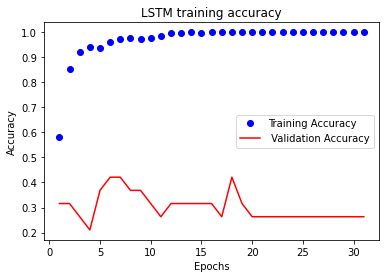

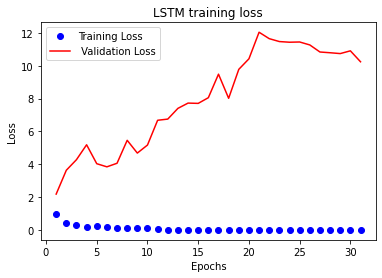

In [16]:
# Plot the training results
import matplotlib.pyplot as plt 

# Visualize the and accuracy loss during training
history_dict = history.history

training_loss = history_dict["loss"]
training_accuracy = history_dict["accuracy"]

validation_accuracy = history_dict["val_accuracy"]
validation_loss = history_dict["val_loss"]

epochs = range(1, len(training_loss)+1) 

# Plot the train/val accuracy
plt.plot(epochs, training_accuracy, 'bo', label="Training Accuracy")
plt.plot(epochs, validation_accuracy, 'r', label=" Validation Accuracy")

plt.title("LSTM training accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig(filename+"_accuracy", dpi=300)
plt.show()

plt.figure()

# Plot the train/val loss
plt.plot(epochs, training_loss, 'bo', label="Training Loss")
plt.plot(epochs, validation_loss, 'r', label=" Validation Loss")

plt.title("LSTM training loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig(filename+"_loss", dpi=300)
plt.show()

In [17]:
###################################
### Evaluate the model and plot the prediction results ###
###################################

from tensorflow.keras.models import load_model

filepath = filename +".h5"
model = load_model(filepath, compile=True)

# show the confusion matrix 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

predictions = model.predict(X_test)
predictions = np.argmax(predictions, axis=1)
true_labels = y_test

cm = confusion_matrix(true_labels, predictions)


Classification report:
               precision    recall  f1-score   support

         2.0      0.444     0.800     0.571         5
         2.5      0.000     0.000     0.000         8
           3      0.250     0.400     0.308         5
         3.5      0.000     0.000     0.000         1

    accuracy                          0.316        19
   macro avg      0.174     0.300     0.220        19
weighted avg      0.183     0.316     0.231        19

 
Confusion Matrix: 



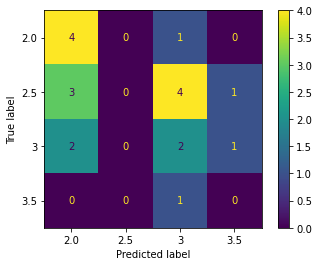

In [18]:
# Set the labels
target_names = ['2.0','2.5','3','3.5']

# Display the classification report
print("\nClassification report:\n", classification_report(true_labels, predictions, target_names = target_names, digits = 3))

print(" ")
print("Confusion Matrix: \n")
# Compute confusion matrix

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = target_names)
disp = disp.plot()
plt.savefig(filename+"_confusion_matrix", dpi=300)
plt.show()


In [19]:
    "from keras.utils import plot_model\n",
    "plot_model(CNN_model,\n",
    "    to_file=\"CNN_model3.png\",\n",
    "    show_shapes=True,\n",
    "    show_layer_names=True,\n",
    "    rankdir=\"TB\",\n",
    "    expand_nested=False,\n",
    "    dpi=96,\n",
    ")"

')'